In [1]:
!pip install sec_api

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np
import time
import requests
import json
from sec_api import QueryApi
from IPython.display import display, HTML

api_key = "ae5eb13df2068fda9c1fb495aa6839cf10b03a92a9f04e50c5f07d200156f0ba"

def fetch_filings(api_key):

    # get your API key at https://sec-api.io
    query_api = QueryApi(api_key= api_key)

    # fetch all 10-K filings for SouthWestern Airlines
    query = {
        "query": {
            "query_string": {
                "query": "(formType:\"10-K\") AND ticker:LUV"
            }
        },
        "from": "0",
        "size": "3",
        "sort": [{ "filedAt": { "order": "desc" } }]
    }

    query_result = query_api.get_filings(query)
    # load JSON into memory
    #xbrl_json = json.loads(response.text)

    accession_numbers = []

    # extract accession numbers of each filing
    for filing in query_result['filings']:
        accession_numbers.append(filing['accessionNo']);
    return accession_numbers

def fetch_filings_quarterly(api_key):

    # get your API key at https://sec-api.io
    query_api = QueryApi(api_key= api_key)

    # fetch all 10-K filings for SouthWestern Airlines
    query = {
        "query": {
            "query_string": {
                "query": "(formType:\"10-Q\") AND ticker:LUV"
            }
        },
        "from": "0",
        "size": "20",
        "sort": [{ "filedAt": { "order": "desc" } }]
    }

    query_result = query_api.get_filings(query)
    # load JSON into memory
    #xbrl_json = json.loads(response.text)

    accession_numbers = []

    # extract accession numbers of each filing
    for filing in query_result['filings']:
        accession_numbers.append(filing['accessionNo']);
    return accession_numbers

# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no, retry = 0):
    xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + api_key

    # linear backoff in case API fails with "too many requests" error
    try:
      response_tmp = requests.get(request_url)
      xbrl_json = json.loads(response_tmp.text)
    except:
      if retry > 5:
        raise Exception('API error')
      
      # wait 500 milliseconds on error and retry
      time.sleep(0.5) 
      return get_xbrl_json(accession_no, retry + 1)

    return xbrl_json

# clean income statement.
# drop duplicate columns (= column name ends with "_left"), drop key_0 column, drop columns with +5 NaNs
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values, reverse = True)
    
    return statement[sorted_columns]


# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 


# helps printing dataframes while we generate new income statement
def main(accession_numbers):
    previous_income_statement_set = False
    income_statement_final = None
    income_statements = [x[0] for x in enumerate(accession_numbers)]
    for i,accession_no in enumerate(accession_numbers):
    # for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
        print(accession_no)
        # get XBRL-JSON of 10-K filing by accession number
        xbrl_json_data = get_xbrl_json(accession_no)

        # convert XBRL-JSON to a pandas dataframe
        income_statement_uncleaned = get_income_statement(xbrl_json_data)

        # clean the income statement
        income_statement_cleaned = clean_income_statement(income_statement_uncleaned)

        income_statements[i] = income_statement_cleaned
        # print income statement on each iteration to monitor progress
        #display(HTML(income_statement_cleaned.to_html()))

    result = pd.concat(income_statements, axis=1, join="inner")
    result = result.loc[:,~result.columns.duplicated()].copy()
    return result

# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

def plot_variables(result):
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax = result.astype(float)\
                             .loc["NetIncomeLoss"]\
                             .plot.line()
    ax = result.astype(float)\
                             .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                             .plot.line()
    ax.legend(['Net Income', 'Revenue'])
    ax.set_title('Quarterly Revenues and Net Income')

    ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

    plt.ylabel('$ Billions')

    # show all year date ranges
    plt.xticks(ticks=np.arange(len(result.columns)),
               labels=result.columns)

    # format x axis properly
    fig.autofmt_xdate()

    plt.show()

0000092380-22-000007
0000092380-21-000033
0000092380-20-000024


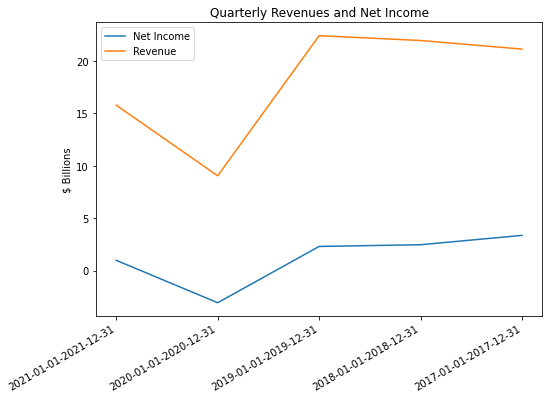

In [3]:

def horizontal_analysis(api_key):
    accession_numbers = fetch_filings(api_key)
    result = main(accession_numbers)
    plot_variables(result)
    

horizontal_analysis(api_key)

In [4]:
#Vertical Analysis for one report

# 10-Q filing URL of SouthWestern
def quarterly_filings(api_key):
    filing_url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0000092380/000009238021000101/luv-20210331.htm"

    # XBRL-to-JSON converter API endpoint
    xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

    final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + api_key

    # make request to the API
    response = requests.get(final_url)

    # load JSON into memory
    xbrl_json = json.loads(response.text)

    return xbrl_json

# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfComprehensiveIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfComprehensiveIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 


In [5]:
# get your API key at https://sec-api.io
api_key = "ae5eb13df2068fda9c1fb495aa6839cf10b03a92a9f04e50c5f07d200156f0ba"

def vertical_analysis(api_key):
    xbrl_json = quarterly_filings(api_key)
    income_statement = get_income_statement(xbrl_json)
    income_statement = income_statement[:-5]
    income_statement = income_statement.apply(pd.to_numeric)
    vertical_analysis = income_statement.divide(income_statement.iloc[0]/100)
    return vertical_analysis

vertical_analysis(api_key)

,2021-01-01-2021-03-31,2020-01-01-2020-03-31
RevenueFromContractWithCustomerExcludingAssessedTax,100.000000,100.000000
LaborAndRelatedExpense,76.559454,43.788380
PayrollSupportAndVoluntaryEmployeeProgramsNet,-70.565302,0.000000
FuelCosts,22.855750,20.547945
AircraftMaintenanceMaterialsAndRepairs,8.430799,6.424185
LandingFeesAndOtherRentals,15.253411,8.006613
DepreciationAndAmortization,15.204678,7.345300
OtherCostAndExpenseOperating,22.563353,16.485593
OperatingCostsAndExpenses,90.302144,102.598016
OperatingIncomeLoss,9.697856,-2.598016
